# <b> Trip Duration Prediction </b>

In [ ]:
!pip install seaborn

In [2]:
import numpy as np
from numpy.ma.core import empty
import pandas as pd
import math
from math import radians, cos, sin, asin, sqrt
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.transforms as mtransforms
import seaborn as sns
from decimal import Decimal, getcontext
from scipy.spatial.distance import cityblock
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2><b> 1. Analyzing the data </b></h2>
<h3><b>1.1 | Removing outliers </b></h3>

In [91]:
# Read the train and test files
train_data = pd.read_csv('/content/drive/MyDrive/Tede/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Tede/test.csv')

In [92]:
# Function that creates a custom graph
def SimplePlot(x, y, x_label, y_label, title, modified=False):
  fig, ax = plt.subplots(figsize =(10, 6))
    
  ax.set_facecolor('#2e2e2e')
  ax.tick_params(colors='white', which='both')
  fig.patch.set_facecolor('#2e2e2e')
  trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=0.2, y=-0.05, units='inches')
  for xs, ys in zip(x, y):
    if(modified == True):
      plt.text(xs, ys, '%d' % (ys) , color="white", transform=trans_offset)
    else:
      plt.text(xs, ys, '%.3f' % (ys) , color="white", transform=trans_offset)
        
  ax.set_title(title, fontsize=16, loc ='left', fontweight ='bold' , color='white')
  plt.xlabel(x_label, fontweight ='bold',  fontsize=12, color='#e8e8e8')
  plt.ylabel(y_label, fontweight ='bold', fontsize=12, color='#e8e8e8')
  plt.plot(x, y, color='#ffb83d', marker='o', markerfacecolor='white', markersize=7)
  plt.grid(color='#525252')

  plt.show()

In [93]:
# We will remove some outliers from the data.

# For the 'trip_duration' feature we will find the maximum and minimum values it can have.
# The values that we will keep are the ones within the range [mean - 2*std, mean + 2*std],
# where 'mean' is the mean value of this column and 'std' is the standard deviation.
upper = train_data['trip_duration'].mean() + 2*train_data['trip_duration'].std()
lower = train_data['trip_duration'].mean() - 2*train_data['trip_duration'].std()

# Every data sample with a 'trip_duaration' value that is not within that range will be discarded.
new_train_data = train_data[(train_data['trip_duration'] < upper) & (train_data['trip_duration'] > lower)]

new_train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06
mean,1.534260e+00,1.664723e+00,-7.397346e+01,4.075090e+01,-7.397340e+01,4.075182e+01,8.370149e+02
std,4.988251e-01,1.314119e+00,6.230739e-02,3.170862e-02,6.159180e-02,3.645359e-02,6.590678e+02
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073732e+01,-7.399133e+01,4.073592e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075408e+01,-7.397977e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076835e+01,-7.396303e+01,4.076981e+01,1.073000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,1.155600e+04


<hr>
<h3><b>1.2 | Removing places outside the city </b></h3>

In [94]:
# City borders
city_long_border_low = -74.03
city_long_border_high =  -73.75

city_lat_border_low = 40.63
city_lat_border_high = 40.85

# Remove any data samples that have pickup or dropoff points outside the city
new_train_data = new_train_data[(new_train_data['pickup_longitude'] < city_long_border_high) & (new_train_data['pickup_longitude'] > city_long_border_low)]
new_train_data = new_train_data[(new_train_data['dropoff_longitude'] < city_long_border_high) & (new_train_data['dropoff_longitude'] > city_long_border_low)]

new_train_data = new_train_data[(new_train_data['pickup_latitude'] < city_lat_border_high) & (new_train_data['pickup_latitude'] > city_lat_border_low)]
new_train_data = new_train_data[(new_train_data['dropoff_latitude'] < city_lat_border_high) & (new_train_data['dropoff_latitude'] > city_lat_border_low)]

new_train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.149733e+06,1.149733e+06,1.149733e+06,1.149733e+06,1.149733e+06,1.149733e+06,1.149733e+06
mean,1.534213e+00,1.664993e+00,-7.397380e+01,4.075101e+01,-7.397358e+01,4.075167e+01,8.246101e+02
std,4.988283e-01,1.314725e+00,3.722962e-02,2.748668e-02,3.260109e-02,2.965198e-02,6.449755e+02
min,1.000000e+00,0.000000e+00,-7.402995e+01,4.063000e+01,-7.403000e+01,4.063000e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073744e+01,-7.399129e+01,4.073629e+01,3.940000e+02
50%,2.000000e+00,1.000000e+00,-7.398178e+01,4.075409e+01,-7.397987e+01,4.075451e+01,6.550000e+02
75%,2.000000e+00,2.000000e+00,-7.396751e+01,4.076831e+01,-7.396350e+01,4.076953e+01,1.057000e+03
max,2.000000e+00,6.000000e+00,-7.375282e+01,4.085000e+01,-7.375008e+01,4.085000e+01,1.155600e+04


<hr>
<h3><b>1.3 | Creating new features using the date and time of each trip  </b></h3>


In [95]:
# Function that returns a datetime object with the given parameters
def time_lim(hour, minute = 0, sec = 0):
  temp = datetime.datetime.now()
  return temp.replace(hour=hour, minute=minute, second=sec, microsecond=0)

# Function that returns the date period based on the time given
def day_period(time):
  if time >= time_lim(6).time() and time <= time_lim(11, 59, 59).time() :
    return 'Morning'
  elif time >= time_lim(12).time() and time <= time_lim(15, 59, 59).time():
    return 'Afternoon'
  elif time >= time_lim(16).time() and time <= time_lim(21, 59, 59).time():
    return 'Evening'
  elif time >= time_lim(22).time() and time <= time_lim(23, 59, 59).time():
    return 'Late Night'
  elif time >= time_lim(0).time() and time <= time_lim(5, 59, 59).time():
    return 'Late Night'

# Function that returns the season based on the month given
def get_season(month):
  months = [[1,2,12],[3,4,5],[6,7,8],[9,10,11]]
  if (month in months[0]):
    return 'Winter'
  elif (month in months[1]):
    return 'Spring'
  elif (month in months[2]):
    return 'Summer'
  elif (month in months[3]):
    return 'Autum'

In [96]:
# Convert these features to datetime objects
new_train_data['pickup_datetime'] = pd.to_datetime(new_train_data['pickup_datetime'])
new_train_data['dropoff_datetime'] = pd.to_datetime(new_train_data['dropoff_datetime'])
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'])

In [97]:
# Initialize some lists that will be used
dropoff_day_period_list = []
pickup_day_period_list = []
days = []
months = []
hours = []
years = []
season = []

for i in range(2):
    days.append([])
    months.append([])
    hours.append([])
    years.append([])
    season.append([])

In [98]:
# For every trip in the train data do the following
for row in new_train_data.itertuples():
  # Get the pickup and dropoff day period by calling the function 'day_period()'
  dropoff_day_period_list.append(day_period(row.dropoff_datetime.time()))
  pickup_day_period_list.append(day_period(row.pickup_datetime.time()))

  # Get the pickup and dropoff day name
  days[0].append(row.pickup_datetime.day_name())
  days[1].append(row.dropoff_datetime.day_name())

  # Get the pickup and dropoff month
  months[0].append(row.pickup_datetime.month)
  months[1].append(row.dropoff_datetime.month)

  # Get the pickup and dropoff hour
  hours[0].append(row.pickup_datetime.hour)
  hours[1].append(row.dropoff_datetime.hour)

  # Get the pickup and dropoff year
  years[0].append(row.pickup_datetime.year)
  years[1].append(row.dropoff_datetime.year)

  # Get the pickup and dropoff season by calling the function 'get_season()'
  season[0].append(get_season(row.pickup_datetime.month))
  season[1].append(get_season(row.dropoff_datetime.month))

# Add the new features to the train data
new_train_data['pickup_day_period'] = pickup_day_period_list
new_train_data['dropoff_day_period'] = dropoff_day_period_list
new_train_data['pickup_day_name'] = days[0]
new_train_data['dropoff_day_name'] = days[1]
new_train_data['pickup_month'] = months[0]
new_train_data['dropoff_month'] = months[1]
new_train_data['pickup_hour'] = hours[0]
new_train_data['dropoff_hour'] = hours[1]
new_train_data['pickup_year'] = years[0]
new_train_data['dropoff_year'] = years[1]
new_train_data['pickup_season'] = season[0]
new_train_data['dropoff_season'] = season[1]

In [99]:
periods = []
days = []
months = []
hours = []
years = []
season = []

# Do the same thing for the test data
for row in test_data.itertuples():
  periods.append(day_period(row.pickup_datetime.time()))
  days.append(row.pickup_datetime.day_name())
  months.append(row.pickup_datetime.month)
  hours.append(row.pickup_datetime.hour)
  years.append(row.pickup_datetime.year)
  season.append(get_season(row.pickup_datetime.month))

# Add the new features to the test data
test_data['pickup_day_period'] = periods
test_data['pickup_day_name'] = days
test_data['pickup_month'] = months
test_data['pickup_hour'] = hours
test_data['pickup_year'] = years
test_data['pickup_season'] = season

In [100]:
days_str = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
period_str = ["Morning", "Afternoon", "Evening", "Late Night"]
months_str = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

pickup_results = []
dropoff_results = []
pickup_period_results = []
dropoff_period_results = []

# For every trip replace the day names and day periods with a number and store them in lists (1-7 for days and 1-4 for day periods)
for row in new_train_data.itertuples():
  index = days_str.index(row.pickup_datetime.day_name())
  pickup_results.append(index+1)

  index = days_str.index(row.dropoff_datetime.day_name())
  dropoff_results.append(index+1)

  index = period_str.index(row.pickup_day_period)
  pickup_period_results.append(index)

  index = period_str.index(row.dropoff_day_period)
  dropoff_period_results.append(index)
  
# Create a dataframe that stores all the numbers for the days and day periods
dayFrame = pd.DataFrame()
dayFrame["pickup_days"] = pickup_results
dayFrame["dropoff_days"] = pickup_results
dayFrame["pickup_period"] = pickup_period_results
dayFrame["dropoff_period"] = dropoff_period_results

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f128f4b4dd0>],
      dtype=object)

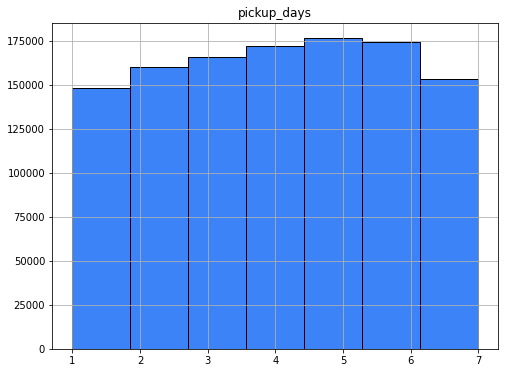

In [14]:
# Create a histogram for the busiest pickup days
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
dayFrame.hist(column="pickup_days", bins = 7, color='#3b83f7', edgecolor='k', ax = ax)

This histogram shows that the pickup days 4, 5, 6 (Wednesday, Thursday, Friday) are the busiest ones, while day 7 (Sunday) is the least busy.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1283aa6990>],
      dtype=object)

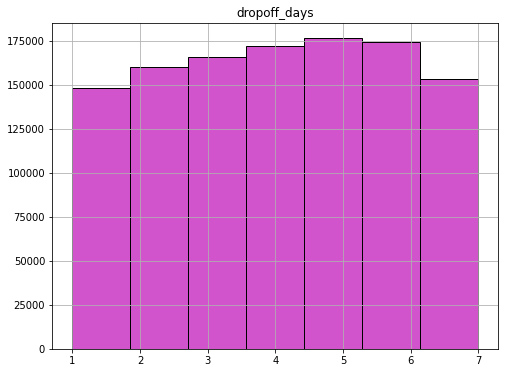

In [15]:
# Create a histogram for the busiest dropoff days
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
dayFrame.hist(column="dropoff_days", bins = 7, color='#d154cd', edgecolor='k', ax = ax)

This histogram for the busiest dropoff days is exactly the same as the one for the pickup days, so the results are the same.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1283e6eb50>],
      dtype=object)

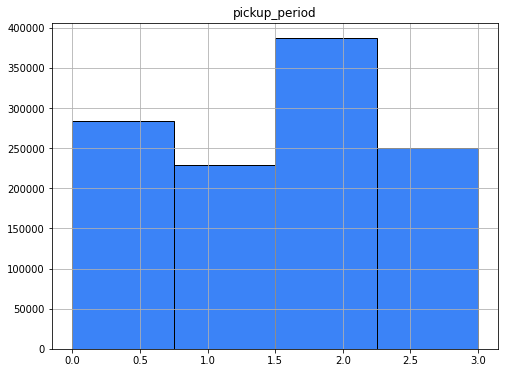

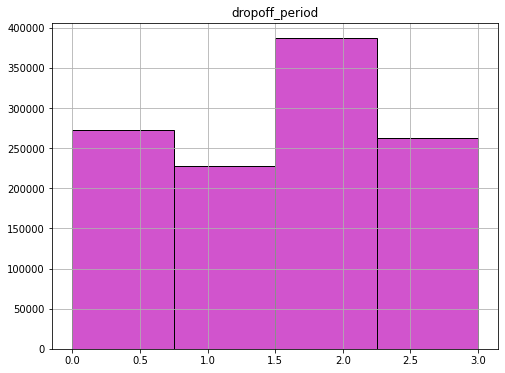

In [16]:
# Create two histograms for the trips per day period (for both pickup and dropoff)
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
dayFrame.hist(column="pickup_period", bins = 4, color='#3b83f7', edgecolor='k', ax = ax)

fig = plt.figure(figsize = (8,6))
ax = fig.gca()
dayFrame.hist(column="dropoff_period", bins = 4, color='#d154cd', edgecolor='k', ax = ax)

These two histograms for the busiest day periods show that the most trips happen in the Evening, while the fewest trips happen in the Afternoon.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f128f4ba490>],
      dtype=object)

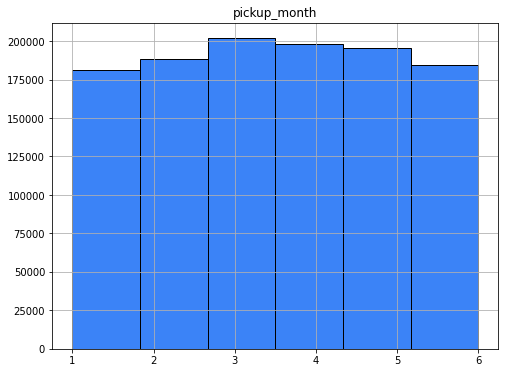

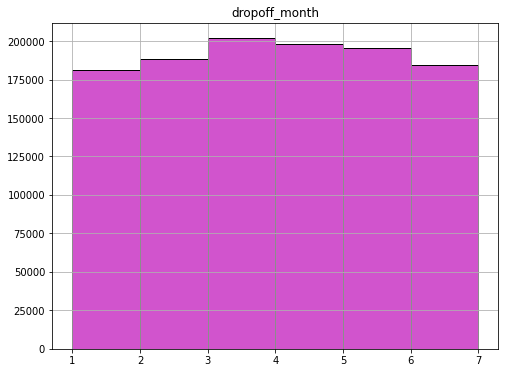

In [17]:
# Create two histograms for the trips per month (for both pickup and dropoff)
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
new_train_data.hist(column="pickup_month", bins = 6, color='#3b83f7', edgecolor='k', ax = ax)

fig = plt.figure(figsize = (8,6))
ax = fig.gca()
new_train_data.hist(column="dropoff_month", bins = 6, color='#d154cd', edgecolor='k', ax = ax)

These two histograms for the busiest months show that the most trips happen in March, April and May while the fewest trips happen in January.

In [101]:
sum=0
index=0
average = []
hours_str = []

for i in range(1,25):
  hours_str.append(i)

# Find the average trip duration per pickup hour
for element in hours_str:
  for row in new_train_data.itertuples():
    if(row.pickup_hour < element and row.pickup_hour >= element-1):
      sum += row.trip_duration
      index += 1
  average.append(sum/index)
  sum=0
  index=0

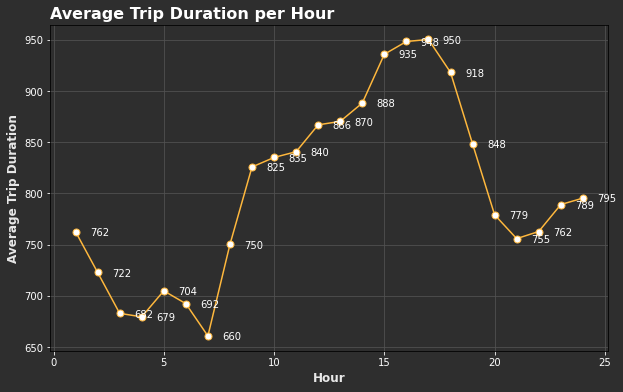

In [19]:
# Plot the average trip duration per pickup hour
SimplePlot(hours_str, average, "Hour", "Average Trip Duration", "Average Trip Duration per Hour", True)

This plot shows the average trip duration for every hour of the day. We can see that the duration starts rising fast after 6:00 AM and it reaches its peak at 17:00 PM. After that it drops significantly for the rest of the day. That could be because of the increased traffic during these hours or the destination of some passengers is further away.

In [102]:
average = []

# Find the average trip duration per day period
for element in period_str:
  for row in new_train_data.itertuples():
    if(element == row.pickup_day_period):
      sum += row.trip_duration
      index += 1
  average.append(sum/index)
  sum=0
  index=0

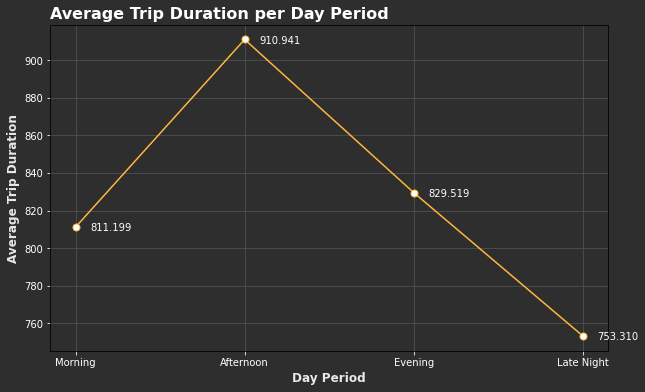

In [21]:
# Plot the average trip duration per day period
SimplePlot(period_str, average, "Day Period", "Average Trip Duration", "Average Trip Duration per Day Period")

This plot shows the average trip duration for every day period. The results are similar to those of the previous plot. It is obvious that the average duration is much higher during the Afternoon for the same reasons that were mentioned before.

In [103]:
average = []

# Find the average trip duration per day of the week
for element in days_str:
  for row in new_train_data.itertuples():
    if(element == row.pickup_day_name):
      sum += row.trip_duration
      index += 1
  average.append(sum/index)
  sum=0
  index=0

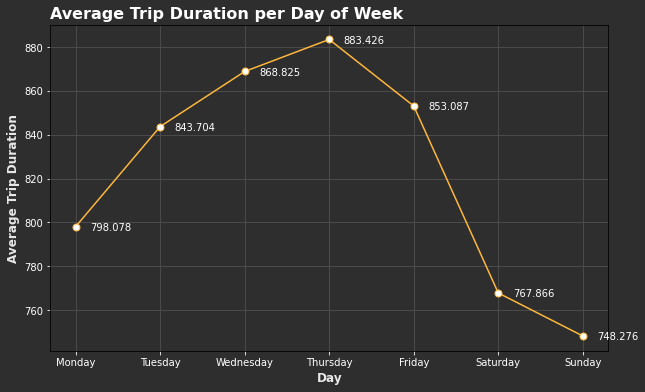

In [23]:
# Plot the average trip duration per day of the week
SimplePlot(days_str, average, "Day", "Average Trip Duration", "Average Trip Duration per Day of Week")

This plot shows the average trip duration for every day of the week. We can see that the duration is high during the weekdays but lower during the weekend. As mentioned before, the reason for that could be the increased traffic because of all the people going to work.

<hr>
<h3><b>1.4 | Visualizing the 'trip_duration' feature and performing log transformation on it </b></h3>

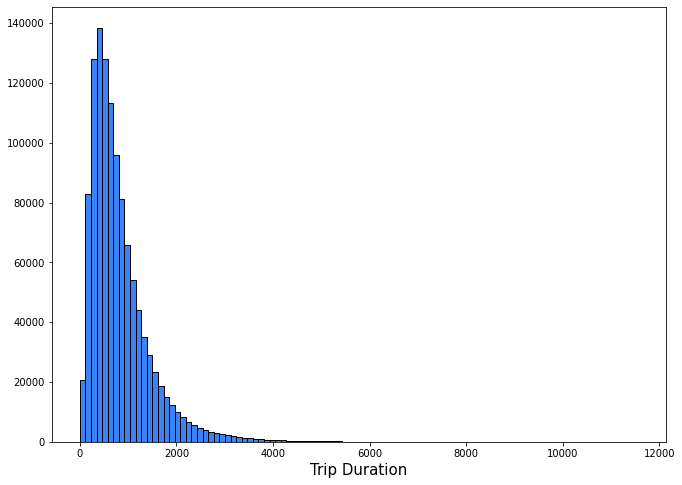

In [24]:
# Creating a histogram for the 'trip_duration' column
fig, ax = plt.subplots(figsize =(11, 8))
ax.hist(new_train_data['trip_duration'], bins = 100, color= '#3b83f7', edgecolor='k')
plt.xlabel('Trip Duration', fontsize=15)
plt.show()

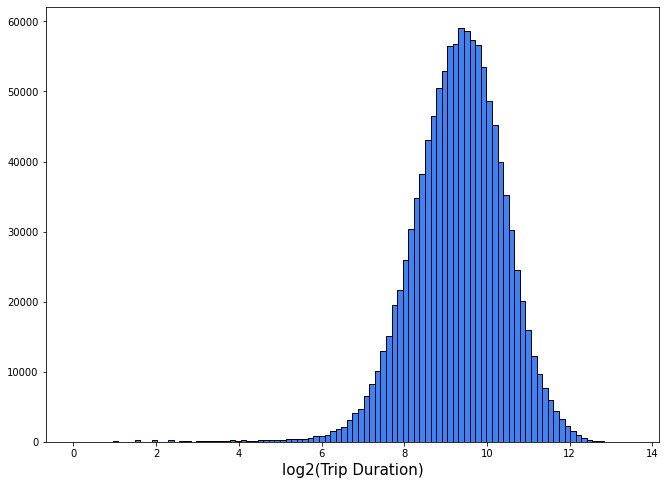

In [104]:
# Performing log transformation on the 'trip_duration' column
new_train_data['log_trip_duration'] = np.log2(new_train_data['trip_duration'])

# Creating a histogram for the 'log_trip_duration' column
fig, ax = plt.subplots(figsize =(11, 8))
ax.hist(new_train_data['log_trip_duration'], bins = 100, color= '#3b83f7', edgecolor='k')
plt.xlabel('log2(Trip Duration)', fontsize=15)
plt.show()

<hr>
<h3><b>1.5 | Find the average trip duration in seconds for each vendor type. </b></h3>

In [105]:
# Function that makes a custom bar plot
def BarGraphFunction(width, height, y_values, x_values, title, x_label, y_label, bar_color = "blue", mod = False):
  
  fig, ax = plt.subplots(figsize =(width, height))
  
  ax.barh(x_values, y_values, color = bar_color)
  
  # Make some small changes to the bar plot's appearance
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)

  
  ax.grid(b = True, color ='white',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)
  
  # Show higher values first
  ax.invert_yaxis()
  

  # Show the value of each bar
  for i in ax.patches:
      plt.text(i.get_width()-50, i.get_y()+0.45,
              str(round((i.get_width()), 2))+"\n Seconds",
              fontsize = 14, fontweight ='bold', ha='right', color='white')

  if(mod == True):
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
  
  ax.set_facecolor('#2e2e2e')
  ax.tick_params(colors='white', which='both')
  fig.patch.set_facecolor('#2e2e2e')
  ax.set_title(title, fontsize=16, loc ='left', fontweight ='bold' , color='white')
  plt.xlabel(x_label, fontweight ='bold', color='#e8e8e8')
  plt.ylabel(y_label, fontweight ='bold', color='#e8e8e8')

  plt.show()

In [106]:
count = 0 
sum = 0
vendor_types = []
averages = []

# Find all the vendor ids
for row in new_train_data.itertuples():
  if  row.vendor_id not in vendor_types:
    vendor_types.append(row.vendor_id)

vendor_types.sort()

# Find the average trip duration for each vendor
for vendor in vendor_types:
  for row in new_train_data.itertuples():
    if (row.vendor_id == vendor):
      sum += row.trip_duration
      count += 1
  
  averages.append(sum / count)
  sum = 0
  count = 0

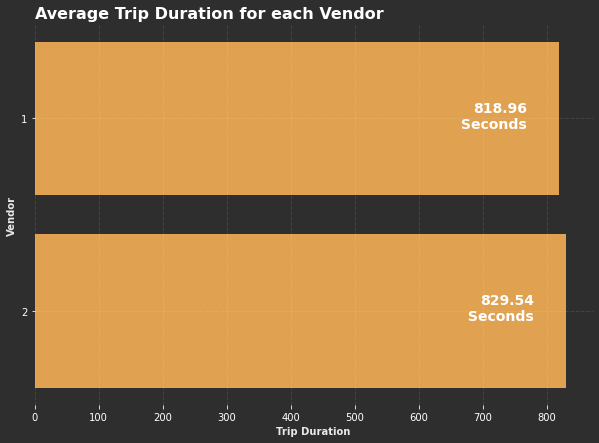

In [28]:
# Plot the average trip duration for each vendor
BarGraphFunction(10, 7, averages, vendor_types, "Average Trip Duration for each Vendor", "Trip Duration", "Vendor", "#e0a251", True)

<hr>
<h3><b>1.6 | Impact of number of passengers on trip duration </b></h3>

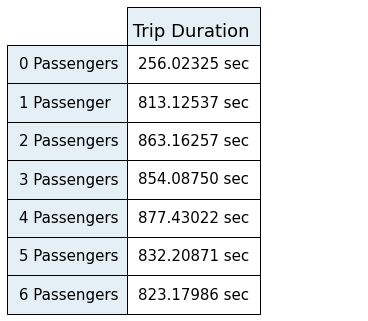

In [107]:
# Find the minimum and maximum number of passengers in all the trips
min_pass = min(new_train_data['passenger_count'])
max_pass = max(new_train_data['passenger_count'])

# Lists to store the total duration and the number of trips for every passenger number
sum_trip_dur = [0]*(max_pass+1)
num_trips = [0]*(max_pass+1)

# Fill the lists
for row in new_train_data.itertuples():
  sum_trip_dur[row.passenger_count] += row.trip_duration
  num_trips[row.passenger_count] += 1

avg_dur = []
for i in range(min_pass, max_pass+1):
  avg_dur.append(str(sum_trip_dur[i]/float(num_trips[i]))[:9] + " sec")

# Create a table with the average trip durations
cell_text = [[avg_dur[0]], [avg_dur[1]], [avg_dur[2]],
             [avg_dur[3]], [avg_dur[4]], [avg_dur[5]],
             [avg_dur[6]]]

table_col = (' ')
table_rows = ['0 Passengers', '1 Passenger', '2 Passengers', '3 Passengers', '4 Passengers', '5 Passengers', '6 Passengers']

row_colors = plt.cm.BuPu(np.full(len(table_rows), 0.1))
col_colors = plt.cm.BuPu(np.full(len(table_col), 0.1))

the_table = plt.table(cellText=cell_text,
                      rowLabels=table_rows,
                      rowColours=row_colors,
                      colLabels=table_col,
                      colColours=col_colors,
                      cellLoc='center',
                      loc='center')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

the_table.auto_set_font_size(False)
the_table.set_fontsize(15)
the_table.auto_set_column_width(col=0)

plt.suptitle(' Trip Duration', fontsize=18)
the_table.scale(2.7, 3.2)

From this table we can see the average trip duration grouped by the number of passengers. The passengers don't seem to have a significant effect on the duration of the trip.

<hr>
<h3><b>1.7 | Manhattan distance </b></h3>

In [108]:
train_manhattan = []
test_manhattan = []

sum_day_dist = [0]*7
sum_days = [0]*7
avg_day_dist = [0]*7
days_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Calculate the manhattan distance for every trip and the average distance for every day of the week
for row in new_train_data.itertuples():
  manhattan_dist = cityblock([row.pickup_latitude, row.pickup_longitude], [row.dropoff_latitude, row.dropoff_longitude])
  train_manhattan.append(manhattan_dist)

  day = row.pickup_datetime.weekday()
  sum_day_dist[day] += manhattan_dist
  sum_days[day] += 1

# Calculate the manhattan distance for the test set as well
for row in test_data.itertuples():
  manhattan_dist = cityblock([row.pickup_latitude, row.pickup_longitude], [row.dropoff_latitude, row.dropoff_longitude])
  test_manhattan.append(manhattan_dist)

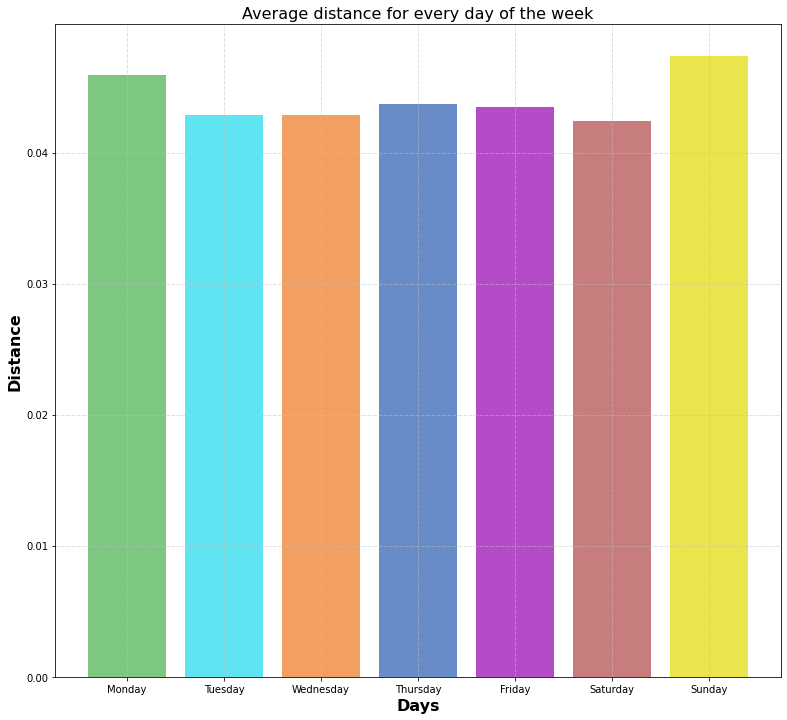

In [109]:
# Add the new columns
new_train_data['manhattan_dist'] = train_manhattan
test_data['manhattan_dist'] = test_manhattan

getcontext().prec = 5
# Find the average distance for every day of the week
for i in range(0, 7):
  avg_day_dist[i] = float(Decimal(sum_day_dist[i]) / Decimal(sum_days[i]))

# Create a bar plot to show the average distance for each day
fig = plt.figure(figsize = (13, 12))

plt.bar('Monday', avg_day_dist[0], color ='#7dc781', width = 0.8)
plt.bar('Tuesday', avg_day_dist[1], color ='#61e4f2', width = 0.8)
plt.bar('Wednesday', avg_day_dist[2], color ='#f2a061', width = 0.8)
plt.bar('Thursday', avg_day_dist[3], color ='#678cc7', width = 0.8)
plt.bar('Friday', avg_day_dist[4], color ='#b44cc7', width = 0.8)
plt.bar('Saturday', avg_day_dist[5], color ='#c77d7d', width = 0.8)
plt.bar('Sunday', avg_day_dist[6], color ='#ebe54d', width = 0.8)

plt.xlabel("Days", fontweight='bold', fontsize=16)
plt.ylabel("Distance", fontweight='bold', fontsize=16)
plt.title("Average distance for every day of the week", fontsize=16)

plt.grid(linestyle='-.', linewidth=0.5 , color='silver', fillstyle='full')
plt.show()

This plot shows the average trip distance for every day of the week. There doesn't seem to be a big difference between all the days but the distance is a bit higher during Sunday and Monday.

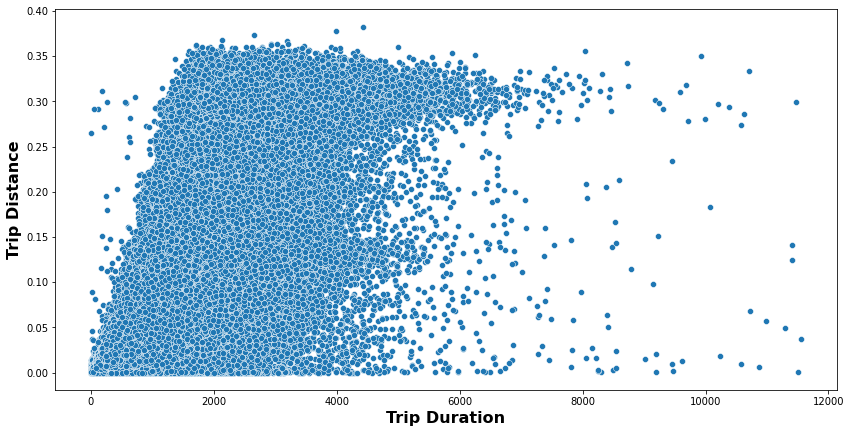

In [32]:
# Create a scatter plot to show the duration and distance of every trip
plt.figure(figsize=(14,7))
plt.xlabel("Trip Duration", fontweight='bold', fontsize=16)
plt.ylabel("Trip Distance", fontweight='bold', fontsize=16)
sns.scatterplot(x=new_train_data['trip_duration'], y=new_train_data['manhattan_dist'])
plt.show()

<hr>
<h3><b>1.8 | Calculate mean distance </b></h3>

In [110]:
months_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Function that finds the average speed for every hour of the day, every day of the week or every month
def AverageSpeedPerCategory(category_list, category_label, plot_label, plot_title):

  average_list = []
  dist_x = 0
  dist_t = 0
  getcontext().prec = 2
  
  # For each element in the category 
  for element in category_list:
    # For each trip
    for row in new_train_data.itertuples():
      # If the category is 'hours' then find the average speed for every hour of the day
      if(category_label == "hours"):
        if(row.pickup_hour == element):
          dist_x += row.manhattan_dist
          dist_t += row.trip_duration/3600
      # If the category is 'days' then find the average speed for every day of the weeks
      elif(category_label == "days"):
        if(row.pickup_day_name == element):
          dist_x += row.manhattan_dist
          dist_t += row.trip_duration/3600
      # Else find the average speed for every month
      else:
        if(row.pickup_month == element):
          dist_x += row.manhattan_dist
          dist_t += row.trip_duration/3600
    
    # Calculate the average speed for that hour/day/month
    if(dist_t == 0):
      average_list.append(0)
    else:
      average_list.append(dist_x / dist_t)
      
    dist_x = 0
    dist_t = 0
  
  # Plot the results
  if(category_label == "months"):
    SimplePlot(months_list, average_list, plot_label, "Average speed", plot_title)
  else:
    SimplePlot(category_list, average_list, plot_label, "Average speed", plot_title)

In [34]:
hours_list = []
for i in range(0,24):
  hours_list.append(i)

week_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months_list = [1, 2, 3, 4, 5, 6]

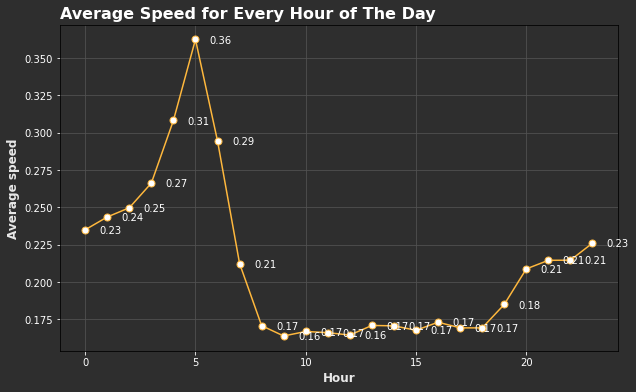

In [37]:
AverageSpeedPerCategory(hours_list, "hours", "Hour", "Average Speed for Every Hour of The Day")

This plot shows the average speed for every hour of the day. The highest speed is recorded after midnight and early in the morning, reaching its peak at 5:00 AM. After that it starts dropping fast, probably because of increased traffic.

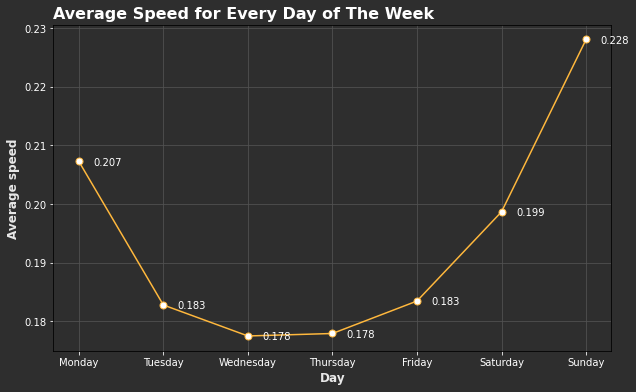

In [39]:
AverageSpeedPerCategory(week_list, "days", "Day", "Average Speed for Every Day of The Week")

This plot shows the average speed for every day of the week. The highest average speed is on Sunday and then it starts dropping until Thursday. After that it starts rising again. It is likely that there is more traffic during the weekdays and that's why the speed drops.

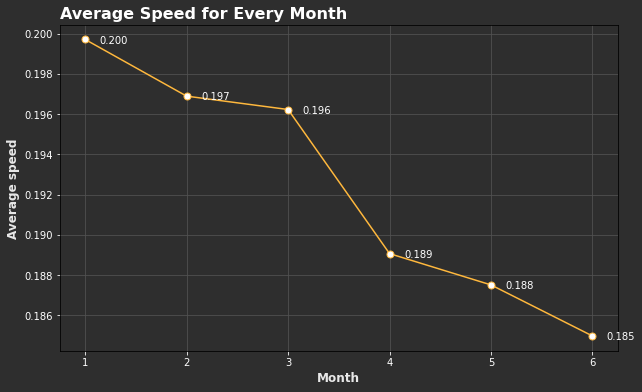

In [40]:
AverageSpeedPerCategory(months_list, "months", "Month", "Average Speed for Every Month")

This plot shows the average speed for every month. The highest average speed is recorded in January but it steadily drops for every month after that.

<hr>
<h3><b>1.9 | Scatter plots of pickup and dropoff spots </b></h3>

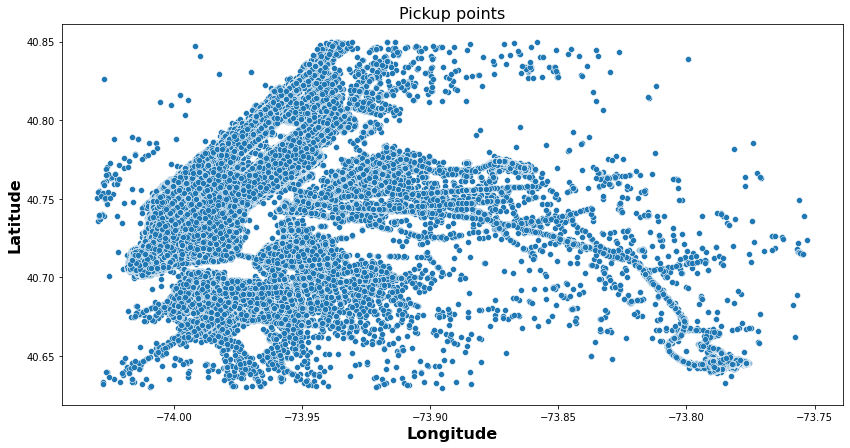

In [41]:
# Create a scatter plot to show the pickup points
plt.figure(figsize=(14,7))
plt.title("Pickup points", fontsize=16)
plt.xlabel("Longitude", fontweight='bold', fontsize=16)
plt.ylabel("Latitude", fontweight='bold', fontsize=16)
sns.scatterplot(x=new_train_data['pickup_longitude'], y=new_train_data['pickup_latitude'])
plt.show()

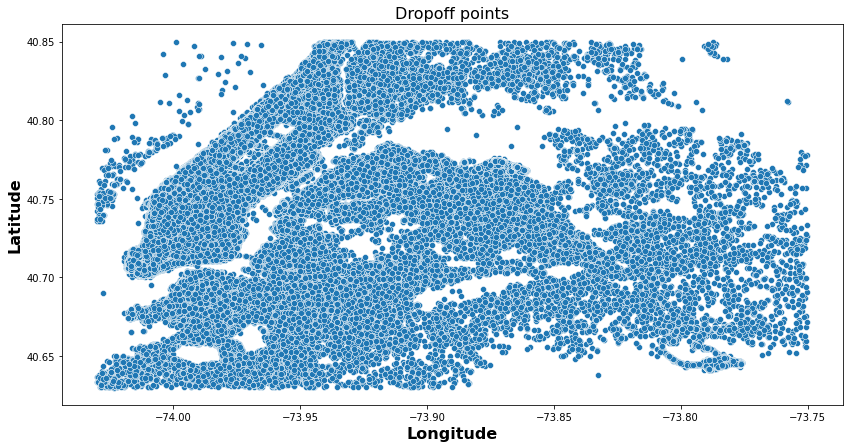

In [42]:
# Create a scatter plot to show the dropoff points
plt.figure(figsize=(14,7))
plt.title("Dropoff points", fontsize=16)
plt.xlabel("Longitude", fontweight='bold', fontsize=16)
plt.ylabel("Latitude", fontweight='bold', fontsize=16)
sns.scatterplot(x=new_train_data['dropoff_longitude'], y=new_train_data['dropoff_latitude'])
plt.show()

<h2><b> 2. Clustering and predicting the trip duration </b></h2>
<h3><b> 2.1 | K-Means </b></h3>

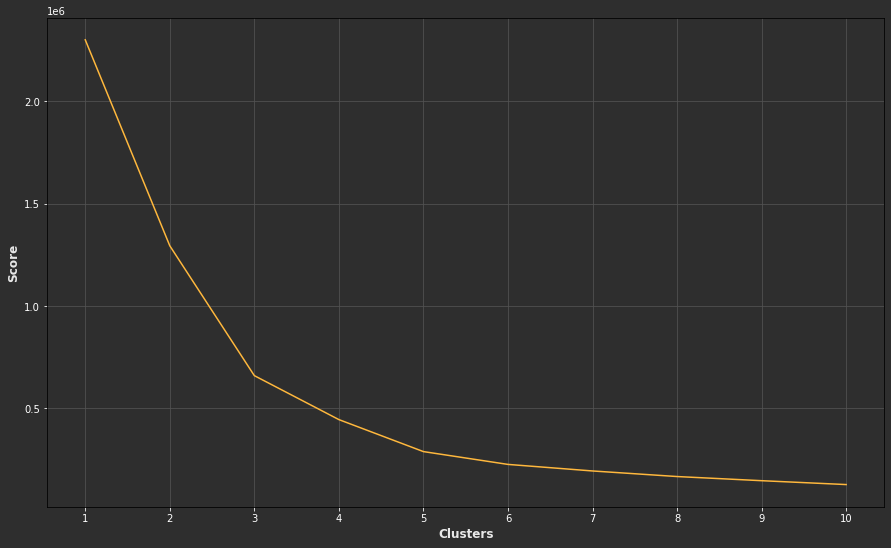

In [111]:
# Get the pickup_latitude and pickup_longitude from the train data
pickup_coordinates = pd.DataFrame()
pickup_coordinates['pickup_longitude'] = new_train_data['pickup_longitude']
pickup_coordinates['pickup_latitude'] = new_train_data['pickup_latitude']

# Scale the train data
scaler = StandardScaler()
pickup_coordinates_scaled = scaler.fit_transform(pickup_coordinates)

# Get the score from KMeans for different number of clusters
kmeans_score = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(pickup_coordinates_scaled)
  kmeans_score.append(kmeans.inertia_)

# Plot all the scores and pick the best one using the 'elbow' method
fig, ax = plt.subplots(figsize =(15, 9))

ax.set_facecolor('#2e2e2e')
ax.tick_params(colors='white', which='both')
ax.patch.set_edgecolor('black')
fig.patch.set_facecolor('#2e2e2e')

plt.xticks(range(1, 11))
plt.xlabel("Clusters", fontweight ='bold',  fontsize=12, color='#e8e8e8')
plt.ylabel("Score", fontweight ='bold', fontsize=12, color='#e8e8e8')
plt.plot(range(1, 11), kmeans_score, color='#ffb83d')
plt.grid(color='#525252')

plt.show()

Using the 'elbow' method we can see that the optimal number of clusters is either 3 or 4. We will choose 3.

In [112]:
# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(pickup_coordinates_scaled)
clusters = kmeans.predict(pickup_coordinates_scaled)

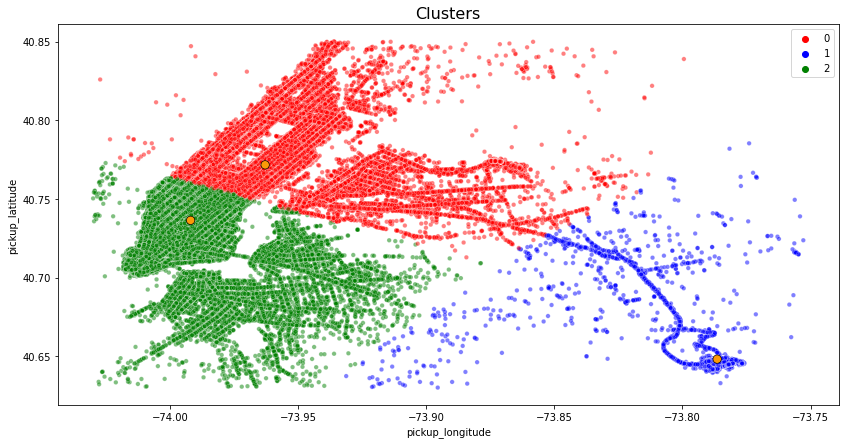

In [113]:
# Create a scatter plot to show the clusters and their centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(14,7))
plt.title("Clusters", fontsize=16)
ax = sns.scatterplot(x=pickup_coordinates['pickup_longitude'], y=pickup_coordinates['pickup_latitude'], hue=clusters, palette=['red', 'blue', 'green'], alpha=0.5, s=20)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], hue=range(3), palette=['#fc9a08', '#fc9a08', '#fc9a08'], s=70, ec='black', legend=False, ax=ax)
plt.show()

<hr>
<h3><b> 2.2 | Trip duration prediction </b></h3>

In [ ]:
# Percentage of the dataset that will be used for training
train_size = int(0.5*len(new_train_data))
X_train = new_train_data.iloc[:train_size]

# Drop the features that will not be needed
X_train = X_train.drop(['id', 'trip_duration', 'log_trip_duration', 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime', 'dropoff_day_period',
                        'dropoff_day_name', 'dropoff_month', 'dropoff_hour', 'pickup_year', 'dropoff_year', 'dropoff_season'], axis=1)

pickup_period_dict = {'Morning': '1', 'Afternoon': '2', 'Evening': '3', 'Late Night': '4'}
pickup_day_dict = {'Monday': '1', 'Tuesday': '2', 'Wednesday': '3', 'Thursday': '4', 'Friday': '5', 'Saturday': '6', 'Sunday': '7'}
pickup_season_dict = {'Winter': '1', 'Spring': '2', 'Summer': '3', 'Fall': '4'}

# Replace the strings in these columns with numbers
X_train["pickup_day_period"] = X_train["pickup_day_period"].replace(pickup_period_dict)
X_train["pickup_day_name"] = X_train["pickup_day_name"].replace(pickup_day_dict)
X_train["pickup_season"] = X_train["pickup_season"].replace(pickup_season_dict)

# Get the column that we want to predict
y_train = pd.DataFrame()
y_train['log_trip_duration'] = new_train_data.iloc[:train_size, 23]

feature_names = []
for col in X_train.columns:
  feature_names.append(col)

# Evaluate how important each feature is by fitting a random forest regressor
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

# Get all the feature importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

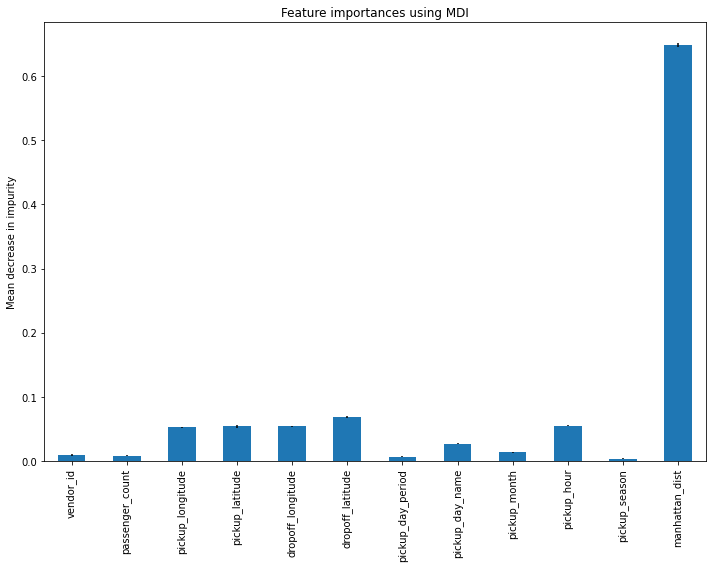

In [115]:
# Plot the feature importances
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<hr>
<h3><b> 2.3 | Finding the best parameters for the estimator </b></h3>

In [116]:
# Function that finds the best parameters for a given estimator using grid search with cross validation
def gridSearch(title, model, parameters, X , y):
  
  kf = KFold(n_splits=10, random_state=None)

  scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']

  # Find the best parameters
  clf = GridSearchCV(model, param_grid=parameters, scoring=scoring, cv=kf, refit='neg_mean_absolute_error')
  clf.fit(X, y)
  
  # Get the mean scores of the best estimator
  bestModel_mse = clf.cv_results_['mean_test_neg_mean_squared_error'][clf.best_index_]
  bestModel_mae = clf.cv_results_['mean_test_neg_mean_absolute_error'][clf.best_index_]

  print(title)
  print("Avg Mean Squared Error: ", bestModel_mse)
  print("Avg Mean Absolute Error: ", bestModel_mae)
  print("Best parameters: ", clf.best_params_)

  return clf.best_params_

In [ ]:
# Set of parameters that GridSearchCV will choose from
parameters = {
    "n_estimators": [100, 200, 400],
    "max_depth" :[4,5,6,7,8],
    "max_features": ['auto', 'sqrt', 'log2']
}

# Drop some less important features
X_train = X_train.drop(['vendor_id', 'passenger_count', 'pickup_day_period', 'pickup_season'], axis=1)

In [119]:
# Perform cross validation and find best parameters
best_param_dict = gridSearch("Average Cross Validation Scores for Random Forest Regression",
                              RandomForestRegressor(), parameters, X_train[:10000], y_train['log_trip_duration'][:10000])

Average Cross Validation Scores for Random Forest Regression
Avg Mean Squared Error:  -0.3895675134800293
Avg Mean Absolute Error:  -0.45620827619983223
Best parameters:  {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 400}


<hr>
<h3><b> 2.4 | Train the estimator with the best parameters </b></h3>

In [120]:
# Percentage of the dataset that will be used for training
test_size = int(0.5*len(test_data))
X_test = test_data.iloc[:test_size]

# Drop the features that will not be needed
X_test = X_test.drop(['id', 'store_and_fwd_flag', 'pickup_datetime', 'pickup_year', 'vendor_id', 'passenger_count', 'pickup_day_period', 'pickup_season'], axis=1)

# Replace the strings of that column with numbers
X_test["pickup_day_name"] = X_test["pickup_day_name"].replace(pickup_day_dict)

In [123]:
# Read the target data file
target_data = pd.read_csv('/content/drive/MyDrive/Tede/target.csv')

In [125]:
# Drop the 'id' features from the target data
target_data = target_data.drop(['id'], axis=1)

# Perform log transformation on the 'trip_duration' feature
target_data['trip_duration'] = np.log2(target_data['trip_duration'])

In [128]:
# Train the model
clf = RandomForestRegressor(n_estimators=best_param_dict['n_estimators'], max_depth=best_param_dict['max_depth'], max_features=best_param_dict['max_features'])
clf.fit(X_train, y_train['log_trip_duration'])

RandomForestRegressor(max_depth=8, n_estimators=400)

<hr>
<h3><b> 2.5 | Predict and find the Mean Absolute Error and Mean Squared Error </b></h3>

In [129]:
# Predict
y_pred = clf.predict(X_test)

# Print the Mean Absolute Error and Mean Squared Error
print("Mean Absolute Error: ", mean_absolute_error(target_data['trip_duration'][:test_size], y_pred))
print("Mean Squared Error: ", mean_squared_error(target_data['trip_duration'][:test_size], y_pred))

Mean Absolute Error:  0.46582649277664645
Mean Squared Error:  0.46793706160218873
